# Import Libraries

In [26]:
%matplotlib inline
from copy import deepcopy
from matplotlib.patches import Rectangle
import natsort as ns
from multiprocessing import cpu_count
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D

# custom libraries
from helpers.helpers import *
from helpers.data_augment import *
from keras_helpers.unet import *
from keras_helpers.helpers import *
from keras_helpers.callbacks import *
from scipy.stats import multivariate_normal
import sys

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

from sklearn import decomposition
from sklearn.utils import class_weight
from keras.utils import to_categorical
from keras.models import load_model

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2749103790752304285
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 130482176
locality {
  bus_id: 2
}
incarnation: 13753013817868357738
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1"
]


In [27]:
# Meta-Parameters
class_to_remove = 4
#base_dir = '/Users/cyrilwendl/Documents/EPFL'  # for local machine
#base_dir = '/home/cyrilwendl'  # for GCE
base_dir = '/raid/home/cwendl'  # for guanabana

sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code/density_tree') # Path to density Tree package

# custom libraries
from density_tree.density_forest import *

# Load Images

In [28]:
path = os.getcwd()

im_dir = r'' + path + '/Zurich_dataset/images_tif/'
gt_dir = r'' + path + '/Zurich_dataset/groundtruth/'

im_names = ns.natsorted(os.listdir(im_dir))
gt_names = ns.natsorted(os.listdir(gt_dir))
print("images: %i " % len(im_names))
print("ground truth images: %i " % len(gt_names))

imgs = np.asarray([im_load(im_dir + im_name) for im_name in im_names])
gt = np.asarray([im_load(gt_dir + gt_name) for gt_name in gt_names])

# histogram stretching
imgs_eq = imgs_stretch_eq(imgs)
imgs = imgs_eq  # continue using stretched image

images: 20 
ground truth images: 20 


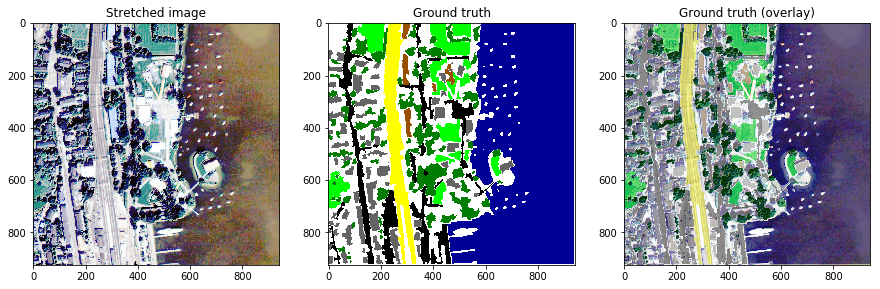

In [29]:
# Show image, its groundtruth image and overlay (to verify matching)
i = 2
alpha=.6
overlay = imgs_eq[i][:, :, :3] * alpha + gt[i] / 255 * (1-alpha)

# TODO don't stretch image

fig, axes = plt.subplots(1,3)
fig.set_size_inches(15,7)
axes[0].imshow(imgs[i][..., :3], cmap='Greys_r')
axes[1].imshow(gt[i]/255, cmap='Greys_r')
axes[2].imshow(overlay, cmap='Greys_r')
axes[0].set_title("Stretched image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
plt.show()

## GT to labels
Next, we need to convert the ground truth (colors) to labels 

In [30]:
legend = OrderedDict((('Background', [255, 255, 255]),
                      ('Roads', [0, 0, 0]),
                      ('Buildings', [100, 100, 100]),
                      ('Trees', [0, 125, 0]),
                      ('Grass', [0, 255, 0]),
                      ('Bare Soil', [150, 80, 0]),
                      ('Water', [0, 0, 150]),
                      ('Railways', [255, 255, 0]),
                      ('Swimming Pools', [150, 150, 255])))

# get class names by increasing value (as done above)
names, colors = [], []
for name, color in legend.items():
    names.append(name)
    colors.append(color)
    
gt_maj_label = gt_color_to_label(gt, colors)

100%|██████████| 9/9 [00:06<00:00,  1.36it/s]


In [31]:
# Load Images
def flatten(l):
    return [item for sublist in l for item in sublist]


flat_labels = flatten(flatten(gt_maj_label))
print("Unique Labels in GT: ", np.unique(flat_labels))
print(np.shape(gt_maj_label))
gt = gt_maj_label

Unique Labels in GT:  [0. 1. 2. 3. 4. 5. 6. 7. 8.]
(20,)


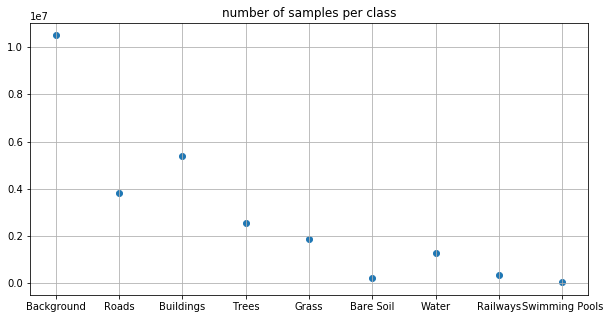

In [32]:
# print some statistics for the class distribution
unique, counts = np.unique(flat_labels, return_counts=True)
_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(unique, counts)
ax.set_title('number of samples per class')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names)
ax.grid()
plt.show()

## Get patches

In [33]:
# Get patches

patch_size = 64
stride_train = 64  # has to be <= patch_size
stride_test = 32  # has to be <= patch_size

# ids for training, validation and test sets (0-19)
ids_train = np.arange(0, 12)
ids_val = np.arange(12, 16)
ids_test = np.arange(16, 20)

# get training, test and validation sets
x_train = get_padded_patches(imgs[ids_train], patch_size=patch_size, stride=stride_train)
x_val = get_padded_patches(imgs[ids_val], patch_size=patch_size, stride=stride_train)
x_test = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=stride_test)
x_test_nostride = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=patch_size)

y_train = get_gt_patches(gt[ids_train], patch_size=patch_size, stride=stride_train)
y_val = get_gt_patches(gt[ids_val], patch_size=patch_size, stride=stride_train)
y_test = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=stride_test)
y_test_nostride = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=patch_size)

print(x_test.shape)
print(x_test_nostride.shape)
print(y_test_nostride.shape)

100%|██████████| 4/4 [00:00<00:00, 158.65it/s]

(3902, 64, 64, 4)
(964, 64, 64, 4)
(964, 64, 64)


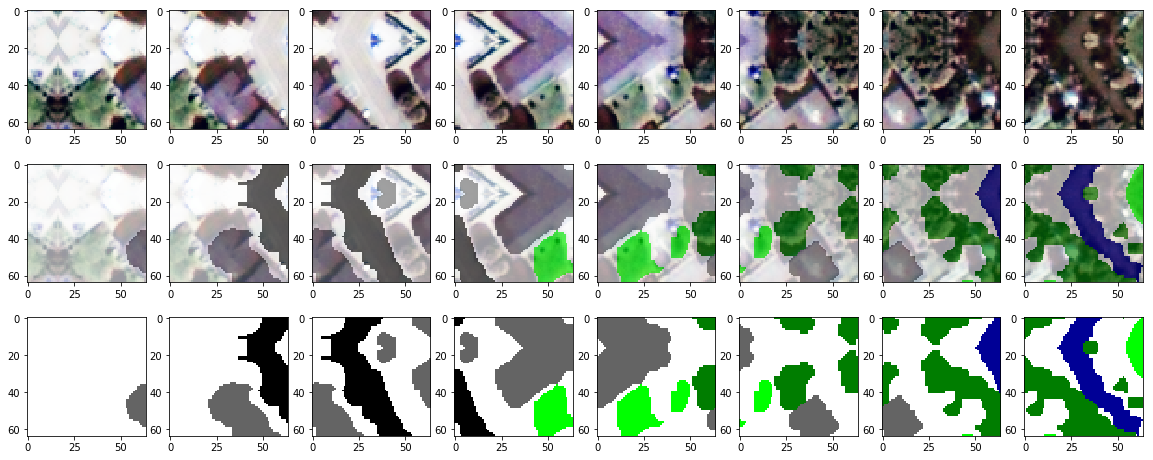

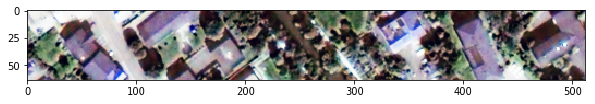

In [34]:
# visualize some patches 
imgs_row = 8
fig, axes = plt.subplots(3, imgs_row)
fig.set_size_inches(20, 8)
offset = 0
alpha = .6
for i in range(offset, offset + imgs_row):
    axes[0][i - offset].imshow(x_test[i][..., :3])  # images
    axes[1][i - offset].imshow(
        gt_label_to_color(y_test[i], colors) * alpha + x_test[i][..., :3] * (1 - alpha))  # ground truth (overlay)
    axes[2][i - offset].imshow(gt_label_to_color(y_test[i], colors))  # ground truth
    
# corresponding part of image
plt.figure(figsize=(10, 5))
plt.imshow(imgs[16][:64, :64 * 8, :3])

# Keras CNN

Data Split: 
- Training: 12 images
- Validation: 4 images
- Test: 4 images

Tested Architectures: 

| Model | Patch Size | Data Augmentations | Number of Parameters | Testing Precision (avg) | Testing Recall (avg) | Testing f1 score (avg) | Validation / Test accuracy |
| ------- | ------- | ------- | ------- | ------- | ------- |
| U-Net | 64 | Rot 90°, Flipping  | 7,828,200 | 0.87 | 0.858 | 0.86 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.69 | 0.61 | 0.64 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.90 | 0.89 | 0.89 | v |

In [35]:
# create copies of original data
x_train_patches = x_train.copy()
x_val_patches = x_val.copy()
x_test_patches = x_test.copy()

y_train_label = y_train.copy()
y_val_label = y_val.copy()
y_test_label = y_test.copy()

In [36]:
# get class weights
labels_unique = np.unique(y_train.flatten())
print(labels_unique)
class_weights = class_weight.compute_class_weight('balanced', labels_unique, y_train.flatten())
class_weights[0] = 0  # give less weight to background label class
class_weights[5] = 7  # give less weight to bare soil class
class_weights[8] = 7  # give less weight to swimming pool class

print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f" % (names[i], w))

[0 1 2 3 4 5 6 7 8]
Class weights:
     Background: 0.000
          Roads: 0.757
      Buildings: 0.480
          Trees: 1.508
          Grass: 2.105
      Bare Soil: 7.000
          Water: 2.006
       Railways: 6.211
 Swimming Pools: 7.000


In [37]:
n_classes = 9

# convert to numpy arrays
x_train = np.asarray(x_train_patches)
x_val = np.asarray(x_val_patches)
x_test = np.asarray(x_test_patches)

# make y data categorical
y_train = to_categorical(y_train_label, n_classes)
y_val = to_categorical(y_val_label, n_classes)

# remove class
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != class_to_remove])

names_keep = np.asarray(names)[classes_to_keep]
names_keep = names_keep.tolist()
print("classes to keep: " + str(names_keep))

y_train = y_train[..., classes_to_keep]
y_val = y_val[..., classes_to_keep]
n_classes = len(classes_to_keep)
class_weights = class_weights[classes_to_keep]

# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))

classes to keep: ['Roads', 'Buildings', 'Trees', 'Bare Soil', 'Water', 'Railways', 'Swimming Pools']
(3897, 64, 64, 4)
(3897, 64, 64, 7)
(1117, 64, 64, 4)
(1117, 64, 64, 7)


## Train CNN

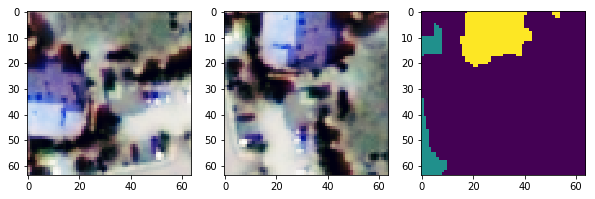

In [13]:
# data augmentation
img_idx = 14
im_patches_vis, gt_patches_vis = augment_images_and_gt(x_train_patches[img_idx], y_train_label[img_idx], rf_h=True,
                                                       rf_v=True, rot=True)

fig, axes = plt.subplots(1, 3)
fig.set_size_inches((10, 5))
axes[0].imshow(x_train_patches[img_idx][..., :3])
axes[1].imshow(im_patches_vis[..., :3])
axes[2].imshow(gt_patches_vis)
plt.show()

In [17]:
# callbacks (evaluated every epoch)
# show loss and accuracy figures after each epoch
callback_plot = PlotLosses()

# stop early if after several epochs the accuracy doesn't improve
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto',
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
file_path = "weights-improvement.hdf5"
callback_checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callback_tensorboard = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

# model setup
batch_size = 20
epochs = 300


def model_train(model, data_augmentation):
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(batch_generator(x_train, y_train,
                                        batch_size=batch_size, data_augmentation=data_augmentation),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        verbose=1,
                        class_weight=class_weights,  # weights for loss function
                        validation_data=(x_val, y_val),
                        callbacks=[callback_earlystop,
                                   callback_lr,
                                   #callback_checkpoint,
                                   callback_plot,
                                   callback_tensorboard],
                        workers=cpu_count(),
                        use_multiprocessing=True)

<Figure size 432x288 with 0 Axes>

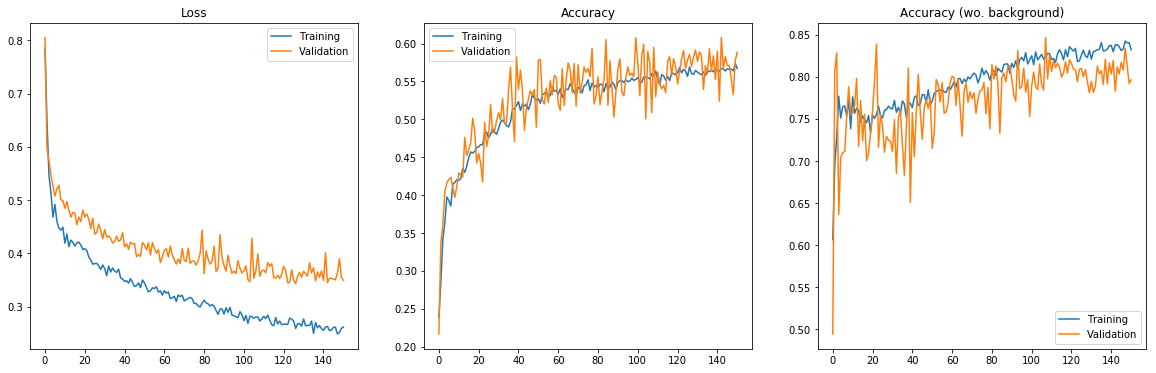

Epoch 00151: early stopping


In [18]:
# train or load model
# train the model
model_unet = get_unet(n_classes, x_train.shape[1:])
model_train(model_unet, data_augmentation=True)
model_unet.save('models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '_2.h5')  # save model, weights

In [53]:
# load model
name_model = path + '/models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '_2.h5'    
model_unet = load_model(name_model, custom_objects={'fn': ignore_background_class_accuracy(0)})

# Prediction on Test Set

In [54]:
# get prediction
y_pred = model_unet.predict(x_test, batch_size=20, verbose=1)

3902/3902 [==============================] - 4s 1ms/step


In [55]:
# prediction patches without overlapping patches
y_pred = np.concatenate(remove_overlap(imgs, y_pred, ids_test, 64, 32))

100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


In [56]:
#y_pred_label = get_y_pred_labels(y_pred)
y_pred_label = get_y_pred_labels(y_pred, class_to_remove=class_to_remove)

# Get accuracy as margin between highest and second highest class
y_pred_acc = get_accuracy_probas(y_pred)

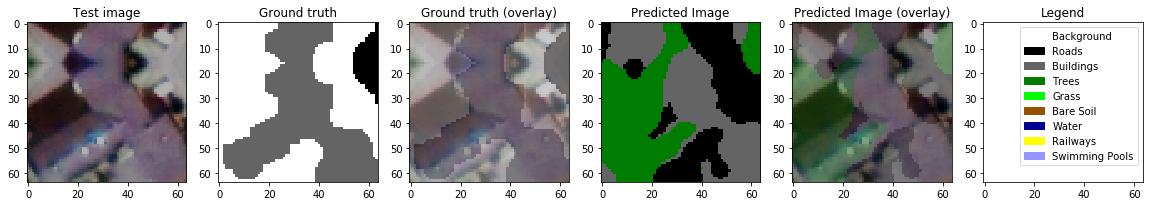

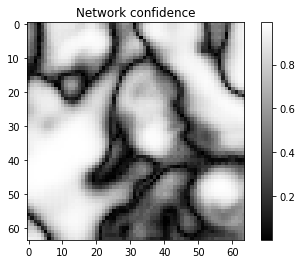

In [57]:
# plot prediction results
im_idx = 15
alpha = .3  # for overlay
fig, axes = plt.subplots(1, 6)
fig.set_size_inches(20, 20)
fig_im = x_test[im_idx][..., :3] * (1 - alpha)
fig_test = gt_label_to_color(y_test_label[im_idx], colors)
fig_pred = gt_label_to_color(y_pred_label[im_idx], colors)

# plots
axes[0].imshow(fig_im)
axes[1].imshow(fig_test)
axes[2].imshow(fig_test * alpha + fig_im * (1 - alpha))
axes[3].imshow(fig_pred)
axes[4].imshow(fig_pred * alpha + fig_im * (1 - alpha))
axes[5].imshow(fig_im * 0 + 1)

# titles
axes[0].set_title("Test image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
axes[3].set_title("Predicted Image")
axes[4].set_title("Predicted Image (overlay)")
axes[5].set_title("Legend")

# legend
legend_data = [[l[0], l[1]] for l in legend.items()]
handles = [Rectangle((0, 0), 1, 1, color=[v / 255 for v in c]) for n, c in legend_data]
labels = np.asarray([n for n, c in legend_data])
axes[5].legend(handles, labels)

# show certitude by network
fig = plt.figure()
plt.imshow(y_pred_acc[im_idx], cmap='gray')
plt.title("Network confidence")
plt.colorbar()

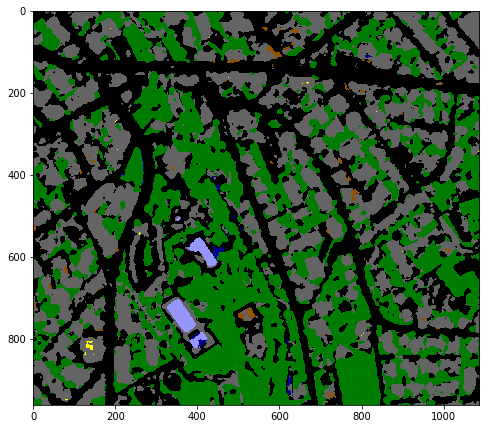

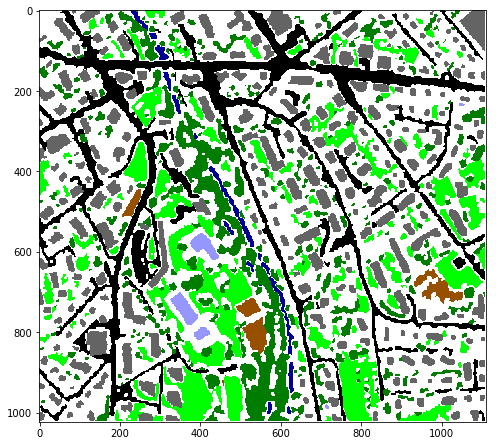

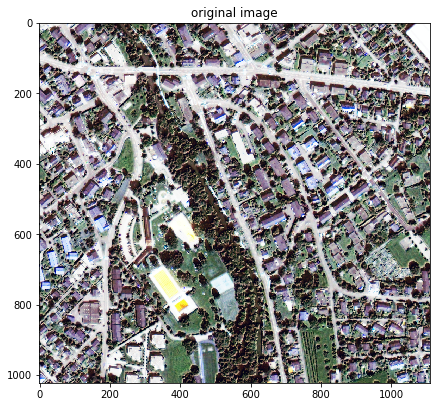

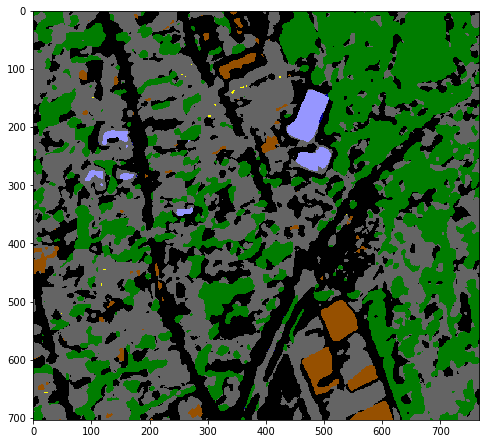

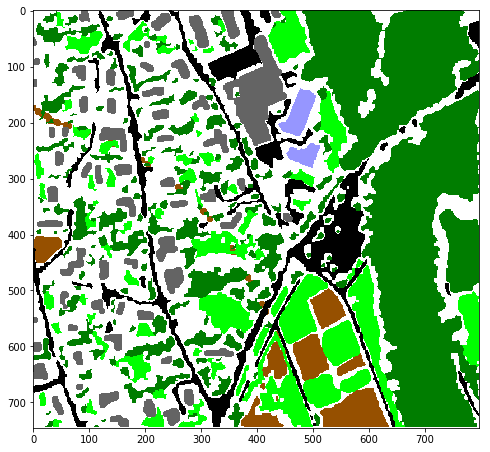

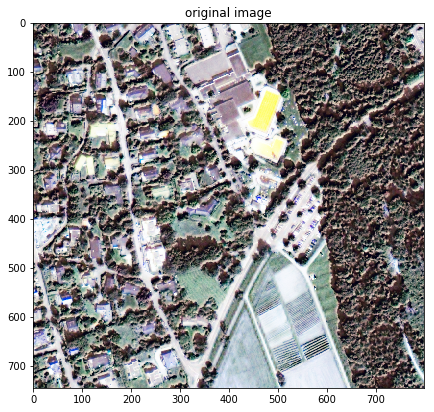

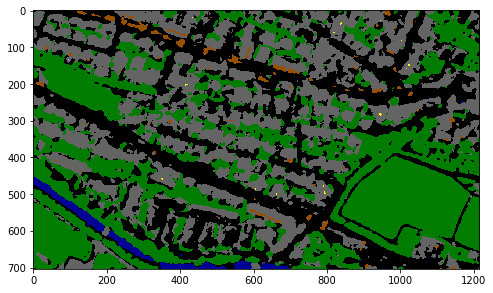

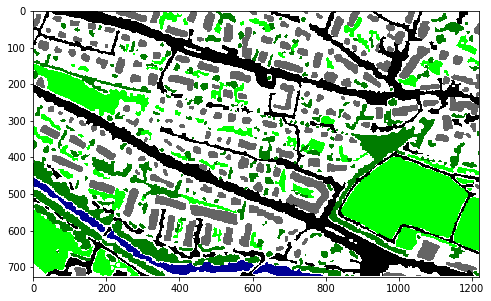

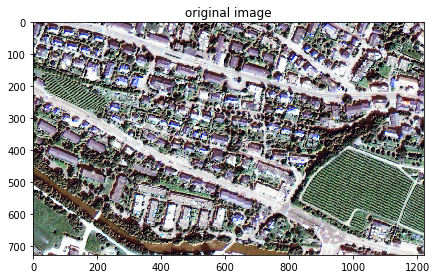

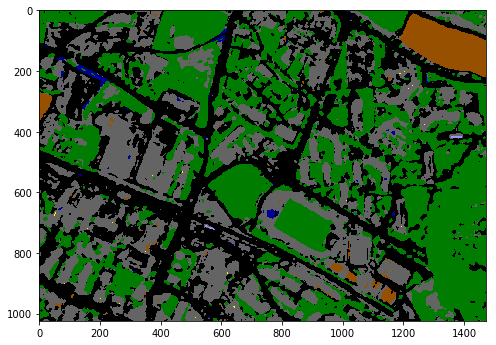

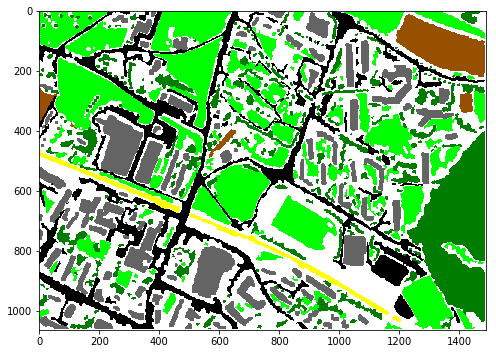

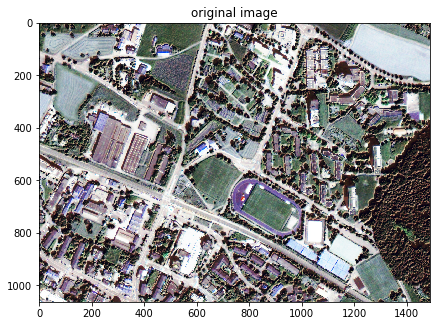

In [58]:
y_pred_im = [
    convert_patches_to_image(imgs, gt_label_to_color(y_pred_label, colors), img_idx=i, img_start=16, patch_size=64,
                             stride=64) for i in ids_test]

for img_idx in ids_test:
    # Pred
    plt.figure(figsize=(8,8))
    plt.imshow(y_pred_im[img_idx-16])  # prediction
    plt.savefig("../Figures/im_" + str(img_idx+1) + "_pred_wo_cl_" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)

    # GT
    plt.figure(figsize=(8,8))
    plt.imshow(gt_label_to_color(gt[img_idx],colors))  # gt stitched together


    # show also original image
    plt.figure(figsize=(7, 7))
    plt.imshow(imgs[img_idx][:, :, :3])
    plt.savefig("../Figures/im_" + str(img_idx+1) + ".pdf", bbox_inches='tight', pad_inches=0)
    plt.title("original image")

# Accuracy Metrics (Test Set)

In [59]:
# Accuracy metrics
y_pred_flattened= np.asarray(flatten(flatten(y_pred_label))).astype('int')
y_test_flattened= np.asarray(flatten(flatten(y_test_nostride))).astype('int')

# mask background and removed classes for evaluation metrics
filter_items = (y_test_flattened != 0) & (y_test_flattened != class_to_remove)

In [60]:
# Class accuracy, average accuracy
print(metrics.classification_report(
    y_pred_flattened[filter_items],
    y_test_flattened[filter_items],
    target_names=names_keep,
    digits=3))

# Overall accuracy
OA = metrics.accuracy_score(y_pred_flattened[filter_items], y_test_flattened[filter_items])
print("Overall accuracy: %.3f %%" % (OA*100))

                precision    recall  f1-score   support

         Roads      0.865     0.750     0.803    600693
     Buildings      0.788     0.732     0.759    506502
         Trees      0.831     0.990     0.904    457789
     Bare Soil      0.676     0.715     0.695     62490
         Water      0.495     0.883     0.634     10486
      Railways      0.000     0.000     0.000      1006
Swimming Pools      0.905     0.848     0.876     11088

   avg / total      0.822     0.811     0.812   1650054

Overall accuracy: 81.076 %


# Certainty using Density Forest

In [61]:
# image, layer indexes
layer_idx = -2
img_idx = 2
batch_size = 20
# get activations for training Density Forest
act_train = get_activations(imgs, model_unet, layer_idx, x_train, ids_train, batch_size=160,
                                  patch_size=64, stride=64)

100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


In [62]:
# get activations for unseen class
filter_unseen = (y_train_label != 0) & (y_train_label == class_to_remove)
act_unseen = np.concatenate(act_train)[filter_unseen]

# retain only activation weights for which there is a ground truth
filter_seen = (y_train_label != 0) & (y_train_label != class_to_remove)
act_seen = np.concatenate(act_train)[filter_seen]

Variance explained by first 10 components: 0.99


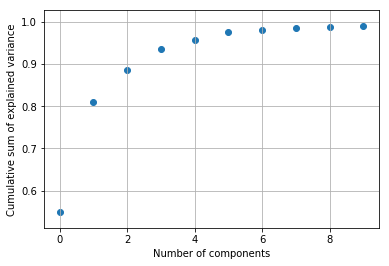

In [63]:
# create density tree for activation weights of training data
# PCA
pca = decomposition.PCA(n_components=0.99)
pca.fit(act_seen)
n_components = np.alen(pca.explained_variance_ratio_)
print("Variance explained by first %i components: %.2f" % (
    n_components, sum(pca.explained_variance_ratio_)))

act_seen = pca.transform(act_seen)
act_unseen = pca.transform(act_unseen)

# validation label
y_seen_1D = y_train_label[filter_seen]

plt.cla()
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid()
plt.show()

In [64]:
# get activations for testing Density Forest
act_test = get_activations(imgs, model_unet, layer_idx, x_test, ids_test, batch_size=160, 
                                  patch_size=64, stride=32)

# remove test activations overlap
act_test_no_overlap = remove_overlap(imgs, np.concatenate(act_test), ids_test, patch_size=64, stride=32) 

100%|██████████| 1/1 [00:02<00:00,  2.01s/it]


In [65]:
act_test = np.concatenate(act_test_no_overlap, axis=0)[y_test_nostride < np.infty] # convert to 1D
act_test = pca.transform(act_test)

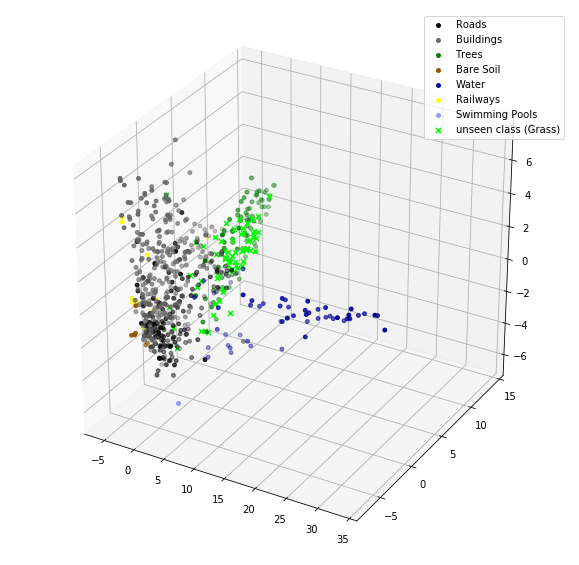

Variance explained by first 3 components: 0.89


In [66]:
# plot PCA points
# get data subset to show in figure
n_points = 600
dataset_indices = np.arange(len(act_seen))

#  draw random samples with replacement
dataset_subset_indices = np.random.choice(dataset_indices, size=n_points, replace=True, )
dataset_subset = act_seen[dataset_subset_indices, :]

dataset_indices = np.arange(len(act_unseen))
dataset_subset_indices_unseen = np.random.choice(dataset_indices, size=int(n_points/9), replace=True, )


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=Axes3D.name)
for class_keep in classes_to_keep:
    plot_data = act_seen[dataset_subset_indices][y_seen_1D[dataset_subset_indices] == class_keep]
    plot_color = y_seen_1D[dataset_subset_indices][y_seen_1D[dataset_subset_indices] == class_keep]
    ax.scatter(plot_data[:, 0], plot_data[:, 1], zs=plot_data[:, 2], c=np.asarray(colors)[class_keep]/255, s=15,
               depthshade=True, marker='o')

ax.scatter(act_unseen[dataset_subset_indices_unseen, 0], act_unseen[dataset_subset_indices_unseen, 1],
           zs=act_unseen[dataset_subset_indices_unseen, 2], c=np.asarray(colors)[class_to_remove]/255, 
           s=25, marker='x', depthshade=False)
names_legend = names_keep.copy()
names_legend.append('unseen class (' + names[class_to_remove] + ')')
ax.legend(names_legend)
plt.savefig("../Figures/pca_components_3d_"+names[class_to_remove]+".pdf", bbox_inches='tight', pad_inches=0)
plt.show()

print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

## Train Density Forest

In [67]:
warnings.filterwarnings("ignore")
subset_data = 0.001
print("Number of points on which to train each tree: %i" % int(np.shape(act_seen)[0] * subset_data))
root_nodes_seen = density_forest_create(act_seen, n_classes, 10, subset_data, n_jobs=-1, verbose=10)

Number of points on which to train each tree: 8503


[Parallel(n_jobs=40)]: Done   3 out of  10 | elapsed:    3.7s remaining:    8.6s
[Parallel(n_jobs=40)]: Done   5 out of  10 | elapsed:    3.8s remaining:    3.8s
[Parallel(n_jobs=40)]: Done   7 out of  10 | elapsed:    3.8s remaining:    1.6s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:    3.9s finished


In [68]:
def my_normal(x, mu, cov):
    """Custom function for calculating the PDF probability of a multivariate normal distribution"""
    a = np.sqrt((2*np.pi) ** x.shape[-1] * np.linalg.det(cov))
    b = -1/2*np.dot(np.dot((x - mu), np.linalg.inv(cov)), (x - mu).T)
    return 1/a*np.exp(b)

def density_forest_traverse_x(dataset, root_nodes, thresh=.1, method='normal'):
    """
    traverse density forest and get mean probability for point to belong to the leaf clusters of each tree
    """
    # set up variables
    pairs_proba = np.empty((len(dataset), len(root_nodes)), float)  # indexes of data points

    # get all clusters for all points in all trees
    for d_idx, d in enumerate(tqdm(dataset)):
        # traverse all trees
        for t_idx, tree in enumerate(root_nodes):
            d_mean, d_cov, d_pct = descend_density_tree(d, tree)
            if d_pct > thresh:
                if method == 'normal':
                    pairs_proba[d_idx, t_idx] = my_normal(d, d_mean, d_cov)
                else:
                    pairs_proba[d_idx, t_idx] = euclidean(d_mean, d)
            else:
                pairs_proba[d_idx, t_idx] = np.nan

    return np.nanmean(pairs_proba, axis=-1)

In [ ]:
# get probabilities for all images
n_jobs = 8
patches_start = get_offset(imgs, 64, 64, 16, 16)
patches_end = get_offset(imgs, 64, 64, 16, 20)
probas = Parallel(n_jobs=n_jobs, verbose=10)(
    delayed(density_forest_traverse)(
        act_test[patch_idx * (patch_size * patch_size):(patch_idx + 1) * (patch_size * patch_size), :],
        root_nodes_seen, thresh=.1, method='normal')
    for patch_idx in range(patches_start, patches_end + 1))

 13%|█▎        | 549/4096 [00:00<00:03, 907.62it/s]][Parallel(n_jobs=8)]: Done 129 tasks      | elapsed:  2.2min


100%|██████████| 4096/4096 [00:08<00:00, 462.09it/s]


 71%|███████   | 2897/4096 [00:07<00:03, 390.00it/s]

In [ ]:
# reshape probas to (n_patches, patch_size, patch_size)
patches_start = get_offset(imgs, 64, 64, 16, 16) # idx of first patch in image
patches_end = get_offset(imgs, 64, 64, 16, 20) # idx of first patch in image
n_patches = patches_end-patches_start
probas_seen_im = np.reshape(np.asarray(probas[:-1]), (n_patches,patch_size,patch_size))

In [ ]:
# standardize between 0 and 1
probas_seen_im = probas_seen_im-np.nanmin(probas_seen_im)
probas_seen_im = probas_seen_im/np.nanmax(probas_seen_im)
#m=2
#probas_seen_im[abs(probas_seen_im - np.nanmean(probas_seen_im)) > m * np.nanstd(probas_seen_im)] = np.nan

In [ ]:
# save probabilities corresponding to an image in an array
probas_imgs = [] # (n_imgs, n_patches, patch_size, patch_size)
for idx_im in ids_test:
    patches_start = get_offset(imgs, 64, 64, 16, idx_im) # idx of first patch in image
    patches_end = get_offset(imgs, 64, 64, 16, idx_im+1) # idx of last patch in image
    probas_im = np.asarray(probas_seen_im[patches_start:patches_end])
    probas_imgs.append(probas_im)

In [ ]:
# plot prediction results with new uncertainty
#  %matplotlib inline
idx_im=16
idx_offset = get_offset(imgs, 64, 64, 16, idx_im)
idx_patch = 20
alpha = .3  # for overlay
fig, axes = plt.subplots(1, 6)
fig.set_size_inches(20, 20)
fig_im = x_test_nostride[idx_offset + idx_patch][..., :3] * (1 - alpha)
fig_test = gt_label_to_color(y_test_nostride[idx_offset + idx_patch], colors)
fig_pred = gt_label_to_color(y_pred_label[idx_offset + idx_patch], colors)

# plots
axes[0].imshow(fig_im)
axes[1].imshow(fig_test)
axes[2].imshow(fig_test * alpha + fig_im * (1 - alpha))
axes[3].imshow(fig_pred)
axes[4].imshow(fig_pred * alpha + fig_im * (1 - alpha))
axes[5].imshow(fig_im * 0 + 1)

# titles
axes[0].set_title("Test image")
axes[1].set_title("Ground truth")
axes[2].set_title("Ground truth (overlay)")
axes[3].set_title("Predicted Image")
axes[4].set_title("Predicted Image (overlay)")
axes[5].set_title("Legend")

# legend
legend_data = [[l[0], l[1]] for l in legend.items()]
handles = [Rectangle((0, 0), 1, 1, color=[v / 255 for v in c]) for n, c in legend_data]
labels = [n for n, c in legend_data]
axes[5].legend(handles, labels)

# show certitude by network
im_overlay = get_fig_overlay(fig_im, probas_imgs[idx_im-16][idx_patch], thresh=.15, opacity=.4)
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(14, 6)
f1 = axes[0].imshow(y_pred_acc[idx_offset + idx_patch], cmap='gray')
fig.colorbar(f1, ax=axes[0], orientation='horizontal')
f2 = axes[1].imshow(probas_imgs[idx_im-16][idx_patch], cmap='gray')
fig.colorbar(f2, ax=axes[1], orientation='horizontal', spacing='proportional')
axes[0].set_title("Network Confidence")
axes[1].set_title("Density Forest")
axes[2].imshow(im_overlay)
plt.show()

In [ ]:
# convert patches to image
idx_im = 18


# show certitude by network
# image, overlay
from ipywidgets import interact, FloatSlider
im_cert_out = convert_patches_to_image(imgs, probas_imgs[idx_im-16][..., np.newaxis],
                                       img_idx=idx_im, patch_size=64,
                                       stride=64, img_start=idx_im)

def fig_uncertainty(thresh, save=False, show=True):
    #thresh=thresh*1e-5
    
    im_overlay = get_fig_overlay(imgs[idx_im][:im_cert_out.shape[0],:im_cert_out.shape[1],:3],im_cert_out[...,0],
                             thresh=thresh,opacity=.5)

    fig = plt.figure(figsize=(12,12))
    plt.imshow(im_overlay)
    if save:
        plt.savefig("../Figures/im_" + str(idx_im+1) + "_tr_" + str(thresh) + "_wo_cl_" +
                    str(names[class_to_remove]).lower() + ".pdf", bbox_inches='tight', pad_inches=0)
    if show:
        plt.show()

fig_uncertainty(.1e-3)
#interact(fig_uncertainty,thresh=(0,1e-5,1e-3))

In [ ]:
"""
for idx_im in ids_test:
    im_cert_out = convert_patches_to_image(imgs, probas_imgs[idx_im-16][..., np.newaxis],
                                       img_idx=idx_im, patch_size=64,
                                       stride=64, img_start=idx_im)
    for thresh in np.asarray([.2, .4]):

        fig_uncertainty(thresh, save=False, show=False)
"""

In [ ]:
# prediction image
y_pred_acc_imgs = [convert_patches_to_image(imgs, y_pred_acc[...,np.newaxis],
                                       img_idx=idx_im, img_start=ids_test[0], patch_size=64,
                                       stride=64) for idx_im in ids_test]

In [ ]:
for idx_im in ids_test:
    im_cert_out = convert_patches_to_image(imgs, 1-probas_imgs[idx_im-16][..., np.newaxis],
                                           img_idx=idx_im, patch_size=64,
                                           stride=64, img_start=idx_im)

    fig, axes = plt.subplots(1,2,figsize=(16, 16))
    axes[0].imshow(im_cert_out[..., 0], cmap='gray')
    axes[1].imshow(y_pred_acc_imgs[idx_im-16][...,0],cmap='gray')

    axes[0].set_title("Density Forest Confidence")
    axes[1].set_title("Network Confidence")
    plt.savefig("../Figures/im_" + str(idx_im + 1) + "_confidence_cl_" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0);
    plt.show()

In [ ]:
# calculate average certainty by Density Forest
probas_patches = np.concatenate(probas_imgs) # all patches concatenated (like y_test)
av_cert = []
nans = []
for label in np.arange(1, 9):
    av_cert.append(np.nanmean(probas_patches[y_test_nostride==label]))
    nans.append(np.sum(np.isnan(probas_patches[y_test_nostride==label]))/np.sum(np.ones(np.shape(probas_patches[y_test_nostride==label]))))
av_cert = np.asarray(av_cert)
nans = np.asarray(nans)

print("Average certainty within class:")
for idx, w in enumerate(av_cert):
    print("%15s: %3.5f, nans: %.2f%%" % (names[idx + 1], w, nans[idx]*100))

# ratio unseen class / seen classes
cert_unseen = av_cert[class_to_remove - 1]
cert_seen = np.nanmean(np.asarray(av_cert)[av_cert != cert_unseen])

print("Average certainty seen class:\t\t%.5f" % cert_unseen)
print("Average certainty unseen classes:\t%.5f" % cert_seen)
print("Ratio seen class / unseen classes:\t%.3f" % (cert_seen / cert_unseen))

In [ ]:
# calculate average certainty by Network
av_cert = []
nans = []
for label in np.arange(1, 9):
    av_cert.append(np.nanmean(y_pred_acc[y_test_nostride==label]))
av_cert = np.asarray(av_cert)
nans = np.asarray(nans)

print("Average certainty within class:")
for idx, w in enumerate(av_cert):
    print("%15s: %3.5f" % (names[idx + 1], w))

# ratio unseen class / seen classes
cert_unseen = av_cert[class_to_remove - 1]
cert_seen = np.nanmean(np.asarray(av_cert)[av_cert != cert_unseen])

print("Average certainty seen class:\t\t%.5f" % cert_unseen)
print("Average certainty unseen classes:\t%.5f" % cert_seen)
print("Ratio seen class / unseen classes:\t%.3f" % (cert_seen / cert_unseen))